
# Modelling
<br>


### Import libraries

In [10]:
# sklearn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

# xgboost
from xgboost import XGBClassifier

# utilities
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# preferences
pd.set_option('display.max_columns', None)
%matplotlib inline


### Read in dataset, preview first three rows, and display column and datatype info

In [2]:
# read tsv dataset into pandas df
path = 'data/'                                       #<---local directory path where dataset resides
filename = 'amazon_reviews_us_Luggage_v1_00_processed' #<---name of dataset being processed
ext = '.tsv'                                         #<---file extension (tab seperated values)

cols = ['TARGET',  #<---ratio of helpful votes to total votes above/below median
        'LEM',     #<---lemmas
        'STEM',    #<---stems
        'NOUN',    #<---percentage of nouns
        'ADJ',     #<---percentage of adjectives
        'ADV',     #<---percentage of adverbs
        'VERB',    #<---percentage of verbs
        'CHAR',    #<---number of characters
        'NUM',     #<---number of tokens
        'WORD',    #<---number of words
        'SENT',    #<---number of sentences
        'INTERRO', #<---number of questionss
        'EXCLAM',  #<---number of exclamations
        'COUNT',   #<---number of exclamation points
        'LEN',     #<---average word length
        'AVG',     #<---average sentence length
        'PER',     #<---percentage of questions
        'CAPS',    #<---percentage of capitalized characters
        'STAR',    #<---reviewer's star rating for product
        'MED',     #<---product's median star rating
        'FAV',     #<---reviewer's star rating vs product's median
        'POP',     #<---number of product's reviews
        'DAYS']    #<---days from review date to first review


df = pd.read_csv(path+filename+ext,
                 usecols = cols)

display(df.head(3))
df.info()

,TARGET,LEM,STEM,NOUN,ADJ,ADV,VERB,CHAR,NUM,WORD,SENT,INTERRO,EXCLAM,COUNT,LEN,AVG,PER,CAPS,STAR,MED,FAV,POP,DAYS
0,1,"['strap', 'broke', 'supposed', 'anti', 'theft'...","['strap', 'broke', 'suppos', 'anti', 'theft', ...",0.440000,0.160000,0.080000,0.200000,318,25,63,6,1,2,3,5.047619,10.5,0.166667,0.031447,1,4.0,-3.0,23,2001
1,0,"['absolutely', 'thrilled', 'quality', 'leather...","['absolut', 'thrill', 'qualiti', 'leather', 'b...",0.166667,0.250000,0.416667,0.166667,136,12,26,1,1,3,3,5.230769,26.0,1.000000,0.029412,5,5.0,0.0,2,191
2,0,"['picking', 'luggage', '2', 'week', 'whirlwind...","['pick', 'luggag', '2', 'week', 'whirlwind', '...",0.370968,0.177419,0.096774,0.209677,728,62,140,8,1,2,2,5.200000,17.5,0.125000,0.020604,5,5.0,0.0,3,98


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 23 columns):
TARGET     16242 non-null int64
LEM        16242 non-null object
STEM       16242 non-null object
NOUN       16242 non-null float64
ADJ        16242 non-null float64
ADV        16242 non-null float64
VERB       16242 non-null float64
CHAR       16242 non-null int64
NUM        16242 non-null int64
WORD       16242 non-null int64
SENT       16242 non-null int64
INTERRO    16242 non-null int64
EXCLAM     16242 non-null int64
COUNT      16242 non-null int64
LEN        16242 non-null float64
AVG        16242 non-null float64
PER        16242 non-null float64
CAPS       16242 non-null float64
STAR       16242 non-null int64
MED        16242 non-null float64
FAV        16242 non-null float64
POP        16242 non-null int64
DAYS       16242 non-null int64
dtypes: float64(10), int64(11), object(2)
memory usage: 2.9+ MB



### Combine TF-IDF vectors with extracted features and split train and test sets

In [3]:
# set X to df and drop TARGET, set y to TARGET, and split train and test sets (80/20)
X = df.drop(columns=['TARGET'])
y = df.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# vectorize (and drop) lemmas or stems 
vectorizer = TfidfVectorizer(ngram_range=(1, 2),    #<--- compare unigrams and bigrams
                             max_df=.9, min_df=.1)  #<--- drop top/bottom 10% most common tokens

tfidf_train = vectorizer.fit_transform(X_train.LEM) #<---df.LEM or df.STEM
tfidf_test = vectorizer.transform(X_test.LEM)       #<---df.LEM or df.STEM

# drop lemmas and stems
X_train = X_train.drop(columns=['LEM'])
X_test = X_test.drop(columns=['LEM'])
X_train = X_train.drop(columns=['STEM'])
X_test = X_test.drop(columns=['STEM'])

# check tfidf sparsity
print(f"Average number of NON-ZERO elements per vectorized review: {tfidf_train.nnz / float(tfidf_train.shape[0])}")

# convert tfidf to array and concatenate train and test sets
X_train = pd.concat([pd.DataFrame(tfidf_train.toarray()), X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_test.toarray()), X_test.reset_index()], axis = 1)

# drop extra index
X_train = X_train.drop(columns='index')
X_test = X_test.drop(columns='index')

#scale X_train and X_test for svm
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Average number of NON-ZERO elements per vectorized review: 14.724928807819595



### Optimize random forest, XGBoost, and SVM hyperparameters with gridsearch

In [4]:
"""UNCOMMENT BELOW TO RUN RANDOM FOREST GRID SEARCH"""
# # create dictionary of hyperparameters to tune
# param_grid = {'n_estimators': [100, 500],
#               'criterion': ['gini', 'entropy'],
#               'max_depth': [None, 2, 10],
#               'max_features': [None, 4, 16, 24]}

# # create grid search object and fit to data
# grid_forest = GridSearchCV(RandomForestClassifier(random_state=42),
#                            param_grid,
#                            cv=2,
#                            scoring='f1',
#                            verbose=1,
#                            n_jobs=16)

# grid_forest.fit(X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("pickles/rf_grid.pickle","wb")
# pickle.dump(grid_forest, pickle_out)
# pickle_out.close()
"""UNCOMMENT BELOW TO RUN XGBOOST GRID SEARCH"""
# # create dictionary of hyperparameters to tune
# param_grid = {'learning_rate': [0.1],
#               'max_depth': [None, 2, 3, 4],
#               'min_child_weight': [1, 2, 3],
#               'subsample': [0.5, 0.7],
#               'n_estimators': [300, 400]}

# # create grid search object and fit to data
# grid_boost = Random(XGBClassifier(random_state=42),
#                           param_grid,
#                           cv=2,
#                           scoring='f1',
#                           verbose=1,
#                           n_jobs=-1)

# grid_boost.fit(X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("pickles/xgb_grid.pickle","wb")
# pickle.dump(grid_boost, pickle_out)
# pickle_out.close()
"""UNCOMMENT BELOW TO RUN SVM GRID SEARCH"""
# # create dictionary of hyperparameters to tune
# param_grid = {'kernel': ['rbf'],
#               'C': [2],
#               'gamma': [0.001, 'auto']}

# # # create grid search object and fit to data
# grid_svm = GridSearchCV(SVC(random_state=42),
#                         param_grid,
#                         cv=2,
#                         scoring='accuracy',
#                         verbose=1,
#                         n_jobs=16,
#                         error_score=0)

# grid_svm.fit(scaled_X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("pickles/svm_grid.pickle","wb")
# pickle.dump(grid_svm, pickle_out)
# pickle_out.close()

'UNCOMMENT BELOW TO RUN SVM GRID SEARCH'


### Load optimal hyperparamters and fit and predict on classifiers

In [5]:
# load grid hyperparameters
grid_forest = pd.read_pickle('pickles/rf_grid.pickle')
grid_boost = pd.read_pickle('pickles/xgb_grid.pickle')
grid_svm = pd.read_pickle('pickles/svm_grid.pickle')


"""random forest"""
# print random forest hyperparameters
print("Random Forest:",
      f"num estimators = {grid_forest.best_params_['n_estimators']},",
      f"criterion = {grid_forest.best_params_['criterion']},",
      f"max depth = {grid_forest.best_params_['max_depth']},",
      f"max features = {grid_forest.best_params_['max_features']}")

# instantiate random forest classifier
rf_classifier = RandomForestClassifier(criterion=grid_forest.best_params_['criterion'],
                                       max_depth=grid_forest.best_params_['max_depth'],
                                       max_features=grid_forest.best_params_['max_features'],
                                       n_estimators=grid_forest.best_params_['n_estimators'],
                                       random_state=42)

# fit and predict on random forest classifier
rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)


"""xgboost"""
# print xgboost hyperparameters
print("XGBoost:",
      f"learning rate = {grid_boost.best_params_['learning_rate']},",
      f"max depth = {grid_boost.best_params_['max_depth']},",
      f"min child weight = {grid_boost.best_params_['min_child_weight']},",
      f"subsample = {grid_boost.best_params_['subsample']},",
      f"num estimators = {grid_boost.best_params_['n_estimators']}")

# instantiate xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=grid_boost.best_params_['learning_rate'],
                               max_depth=grid_boost.best_params_['max_depth'],
                               max_child_weight=grid_boost.best_params_['min_child_weight'],
                               subsample=grid_boost.best_params_['subsample'],
                               n_estimators=grid_boost.best_params_['n_estimators'],
                               random_state=42)

# fit and predict on xgboost classifier
xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)


"""support vector machine"""
# print svm hyperparameters
print("SVM:",
      f"kernel = {grid_svm.best_params_['kernel']},",
      f"C = {grid_svm.best_params_['C']},",
      f"gamma = {grid_svm.best_params_['gamma']}")

# instantiate svm classifier
svm_classifier = SVC(kernel = grid_svm.best_params_['kernel'],
                              C = grid_svm.best_params_['C'],
                              gamma = grid_svm.best_params_['gamma'],
                              random_state = 42,
                              probability=True)

# fit and predict on svm classifier
svm_classifier.fit(scaled_X_train, y_train)
svm_train_preds = svm_classifier.predict(scaled_X_train)
svm_test_preds = svm_classifier.predict(scaled_X_test)

Random Forest: num estimators = 500, criterion = entropy, max depth = 2, max features = None
XGBoost: learning rate = 0.1, max depth = 2, min child weight = 2, subsample = 0.7, num estimators = 300
SVM: kernel = rbf, C = 2, gamma = 0.001



### Accuracy, recall, and F1 scores

In [13]:
# print random forest metrics
print('RANDOM FOREST\n')
print(f"Training Accuracy:\t{accuracy_score(y_train, rf_train_preds):.4}",
      f"\tTesting Accuracy:\t{accuracy_score(y_test, rf_test_preds):.4}")

print(f"Training Precision:\t{precision_score(y_train, rf_train_preds):.4}",
      f"\tTesting Precision:\t{precision_score(y_test, rf_test_preds):.4}")

print(f"Training Recall:\t{recall_score(y_train, rf_train_preds):.4}",
      f"\tTesting Recall:\t\t{recall_score(y_test, rf_test_preds):.4}")

print(f"Training F1:\t\t{f1_score(y_train, rf_train_preds):.4}",
      f"\tTesting F1:\t\t{f1_score(y_test, rf_test_preds):.4}")


# print xgboost forest metrics
print('\n\nXGBOOST\n')
print(f"Training Accuracy:\t{accuracy_score(y_train, xgb_train_preds):.4}",
      f"\tTesting Accuracy:\t{accuracy_score(y_test, xgb_test_preds):.4}")

print(f"Training Precision:\t{precision_score(y_train, xgb_train_preds):.4}",
      f"\tTesting Precision:\t{precision_score(y_test, xgb_test_preds):.4}")

print(f"Training Recall:\t{recall_score(y_train, xgb_train_preds):.4}",
      f"\tTesting Recall:\t\t{recall_score(y_test, xgb_test_preds):.4}")

print(f"Training F1:\t\t{f1_score(y_train, xgb_train_preds):.4}",
      f"\tTesting F1:\t\t{f1_score(y_test, xgb_test_preds):.4}")


# print svm metrics
print('\n\nSVM\n')
print(f"Training Accuracy:\t{accuracy_score(y_train, svm_train_preds):.4}",
      f"\tTesting Accuracy:\t{accuracy_score(y_test, svm_test_preds):.4}")

print(f"Training Precision:\t{precision_score(y_train, svm_train_preds):.4}",
      f"\tTesting Precision:\t{precision_score(y_test, svm_test_preds):.4}")

print(f"Training Recall:\t{recall_score(y_train, svm_train_preds):.4}",
      f"\tTesting Recall:\t\t{recall_score(y_test, svm_test_preds):.4}")

print(f"Training F1:\t\t{f1_score(y_train, svm_train_preds):.4}",
      f"\tTesting F1:\t\t{f1_score(y_test, svm_test_preds):.4}")

RANDOM FOREST

Training Accuracy:	0.6306 	Testing Accuracy:	0.6294
Training Precision:	0.5933 	Testing Precision:	0.5958
Training Recall:	0.7688 	Testing Recall:		0.7714
Training F1:		0.6697 	Testing F1:		0.6723


XGBOOST

Training Accuracy:	0.7048 	Testing Accuracy:	0.6337
Training Precision:	0.6845 	Testing Precision:	0.6168
Training Recall:	0.7309 	Testing Recall:		0.6777
Training F1:		0.707 	Testing F1:		0.6458


SVM

Training Accuracy:	0.6727 	Testing Accuracy:	0.6491
Training Precision:	0.6389 	Testing Precision:	0.6223
Training Recall:	0.7549 	Testing Recall:		0.7327
Training F1:		0.6921 	Testing F1:		0.673



### Confusion Matrix 

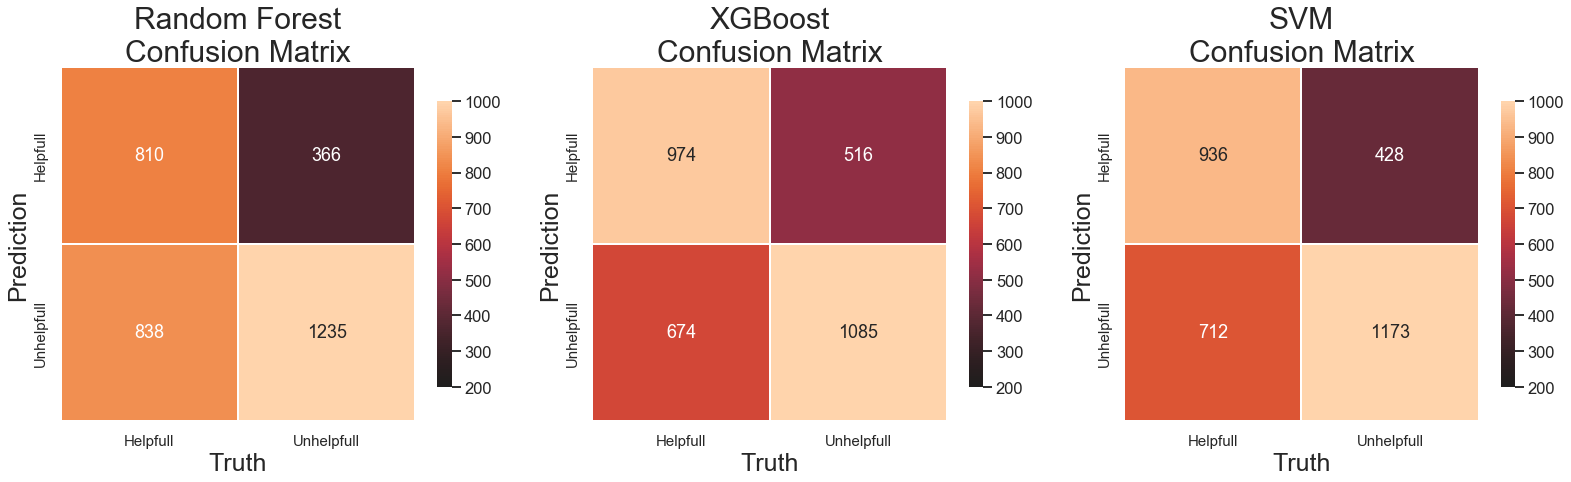

In [14]:
sns.set_palette('dark:salmon_r')
sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 7))


"""random forest"""
# plot random forest confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
### Evaluate model metrics
            ax=ax[0]).set_title('Random Forest\nConfusion Matrix', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Helpfull', 'Unhelpfull'], fontsize=15)
ax[0].set_yticklabels(['Helpfull', 'Unhelpfull'], va='center', fontsize=15)


"""xgboost"""
# plot xgboost confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[1]).set_title('XGBoost\nConfusion Matrix', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Helpfull', 'Unhelpfull'], fontsize=15)
ax[1].set_yticklabels(['Helpfull', 'Unhelpfull'], va='center', fontsize=15)


"""support vector machine"""
# plot svm confusion matrix
sns.heatmap(confusion_matrix(y_test, svm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[2]).set_title('SVM\nConfusion Matrix', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Helpfull', 'Unhelpfull'], fontsize=15)
ax[2].set_yticklabels(['Helpfull', 'Unhelpfull'], va='center', fontsize=15)


plt.savefig(fname='images/conf_mtrx', bbox_inches='tight', pad_inches=.1)
plt.show()


### Evaluate model metrics

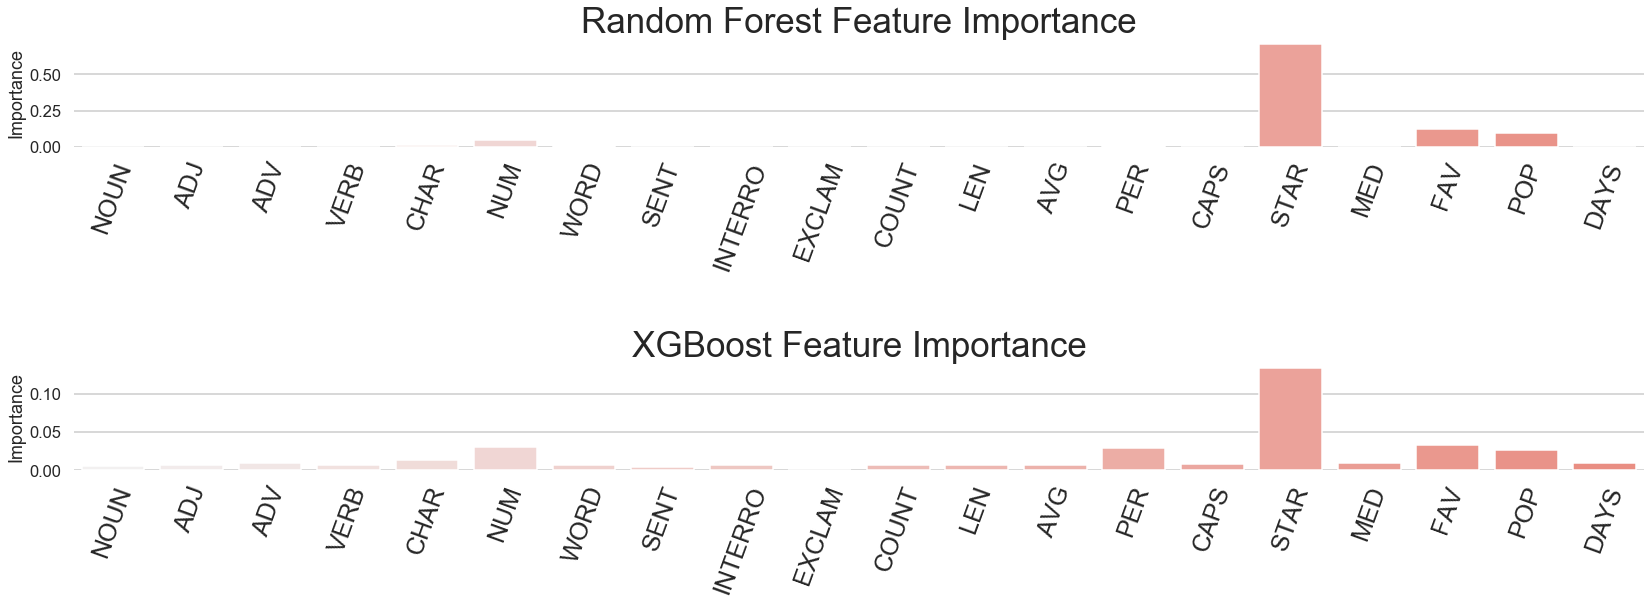

In [28]:
sns.set_style('whitegrid')
sns.set_context("paper")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(23, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=2)


"""random forest"""
# plot random forest feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=rf_classifier.feature_importances_[-20:],
            palette='light:salmon',
            ax=ax[0]).set_title('Random Forest Feature Importance', fontsize=35)

ax[0].set_ylabel('Importance')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

"""xgboost"""
# plot xgboost feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=xgb_classifier.feature_importances_[-20:],
            palette='light:salmon',
            ax=ax[1]).set_title('XGBoost Feature Importance', fontsize=35)

ax[1].set_ylabel('Importance')
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

    
plt.savefig(fname='images/importance', bbox_inches='tight', pad_inches=.1)
plt.show()

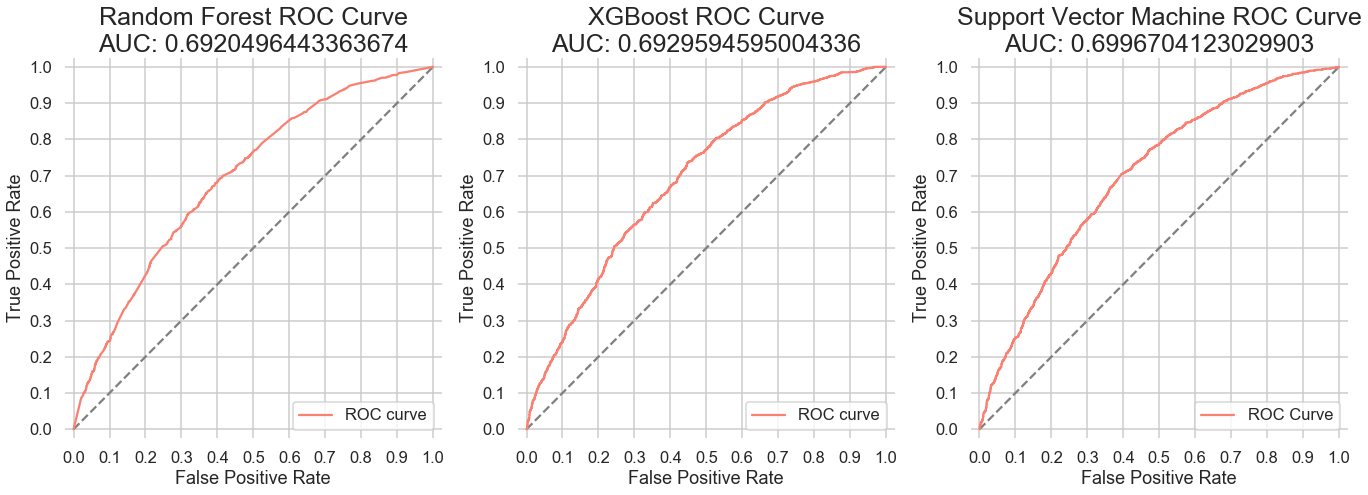

In [9]:
sns.set_palette('light:salmon_r')
sns.set_context("talk")
sns.set_style('whitegrid')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(23, 7))


"""random forest"""
# plot random forest auc curve
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, rf_probs)

sns.despine(bottom = True, left = True)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey', ax=ax[0])
ax[0].plot(fpr, tpr, label='ROC curve')
ax[0].set_xlim([-0.025, 1.025])
ax[0].set_ylim([-0.025, 1.025])
ax[0].set_yticks([i/10.0 for i in range(11)])
ax[0].set_xticks([i/10.0 for i in range(11)])
ax[0].set_xlabel('False Positive Rate', fontsize=18)
ax[0].set_ylabel('True Positive Rate', fontsize=18)
ax[0].set_title(f'Random Forest ROC Curve\nAUC: {auc(fpr, tpr)}', fontsize=25)
ax[0].legend(loc="lower right")


"""xgboost"""
# plot xgboost auc curve
xgb_probs = xgb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, xgb_probs)

sns.despine(bottom = True, left = True)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey', ax=ax[1])
ax[1].plot(fpr, tpr, label='ROC curve')
ax[1].set_xlim([-0.025, 1.025])
ax[1].set_ylim([-0.025, 1.025])
ax[1].set_yticks([i/10.0 for i in range(11)])
ax[1].set_xticks([i/10.0 for i in range(11)])
ax[1].set_xlabel('False Positive Rate', fontsize=18)
ax[1].set_ylabel('True Positive Rate', fontsize=18)
ax[1].set_title(f'XGBoost ROC Curve\nAUC: {auc(fpr, tpr)}', fontsize=25)
ax[1].legend(loc="lower right")


"""support vector machine"""
# plot svm auc curve
svm_probs = svm_classifier.predict_proba(scaled_X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, svm_probs)

sns.despine(bottom = True, left = True)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey', ax=ax[2])
ax[2].plot(fpr, tpr, label='ROC Curve')
ax[2].set_xlim([-0.025, 1.025])
ax[2].set_ylim([-0.025, 1.025])
ax[2].set_yticks([i/10.0 for i in range(11)])
ax[2].set_xticks([i/10.0 for i in range(11)])
ax[2].set_xlabel('False Positive Rate', fontsize=18)
ax[2].set_ylabel('True Positive Rate', fontsize=18)
ax[2].set_title(f'Support Vector Machine ROC Curve\nAUC: {auc(fpr, tpr)}', fontsize=25)
ax[2].legend(loc="lower right")


plt.savefig(fname='images/roc_curve', bbox_inches='tight', pad_inches=.1)
plt.show()